In [3]:
import time
import math
from dataclasses import dataclass
from typing import List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt

In [4]:
import matplotlib
print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


Counter: To store the number of comparisons. 
We pass the same ctr object into every function so all comparisons accumulate in one place

In [5]:
class Counter:
    def __init__(self):
        self.key_comparisons = 0

Define Insertion Sort

In [6]:
def insertion_sort(arr: List[int], left: int, right: int, ctr: Counter) -> None:
    for i in range(left + 1, right + 1):
        key = arr[i]
        j = i - 1

        while j >= left:
            ctr.key_comparisons += 1
            if arr[j] > key:
                arr[j + 1] = arr[j]
                j -= 1
            else:
                break
        arr[j + 1] = key

Defining MergeSort

In [7]:
def merge(arr: List[int], left: int, mid: int, right: int, temp: List[int], ctr: Counter) -> None:
    i, j, k = left, mid + 1, left

    while i <= mid and j <= right:
        ctr.key_comparisons += 1
        if arr[i] <= arr[j]:
            temp[k] = arr[i]
            i += 1
        else:
            temp[k] = arr[j]
            j += 1
        k += 1

    while i <= mid:
        temp[k] = arr[i]
        i += 1
        k += 1

    while j <= right:
        temp[k] = arr[j]
        j += 1
        k += 1

    # copy back
    arr[left:right + 1] = temp[left:right + 1]

Defining Hybrid MergeSort Algorithm

In [8]:
def hybrid_mergesort(arr: List[int], left: int, right: int, S: int, temp: List[int], ctr: Counter) -> None:
    n = right - left + 1
    if n <= 1:
        return
    if n <= S:
        insertion_sort(arr, left, right, ctr)
        return

    mid = (left + right) // 2
    hybrid_mergesort(arr, left, mid, S, temp, ctr)
    hybrid_mergesort(arr, mid + 1, right, S, temp, ctr)
    merge(arr, left, mid, right, temp, ctr)


Defining Run Hybrid: Wraps the algorithm and timing

In [9]:
def run_hybrid(arr: List[int], S: int) -> Tuple[int, float]:
    ctr = Counter()
    temp = [0] * len(arr)
    t0 = time.perf_counter()
    hybrid_mergesort(arr, 0, len(arr) - 1, S, temp, ctr)
    t1 = time.perf_counter()
    return ctr.key_comparisons, (t1 - t0)

Defining Run Plain Mergesort

In [10]:
def run_plain_mergesort(arr: List[int]) -> Tuple[int, float]:
    # Plain mergesort is just hybrid with S=1 (or S=0) but we must ensure it never insertion-sorts.
    # We'll set S=0 so only merge recursion is used.
    ctr = Counter()
    temp = [0] * len(arr)
    t0 = time.perf_counter()
    hybrid_mergesort(arr, 0, len(arr) - 1, S=0, temp=temp, ctr=ctr)
    t1 = time.perf_counter()
    return ctr.key_comparisons, (t1 - t0)


Generating data

In [11]:
def generate_random_array(n: int, x_max: int, seed: Optional[int] = None) -> List[int]:
    rng = np.random.default_rng(seed)
    # integers in [1, x_max]
    a = rng.integers(low=1, high=x_max + 1, size=n, dtype=np.int32)
    return a.tolist()

Experiment: Fixed S but vary n

In [12]:
def experiment_fixed_S_plot_vs_n(
    sizes: List[int],
    S: int,
    x_max: int,
    seed: int = 123,
    trials: int = 1
):
    comps = []
    times = []
    for idx, n in enumerate(sizes):
        # for fairness: new random each trial, but reproducible
        comps_n = []
        times_n = []
        for t in range(trials):
            arr = generate_random_array(n, x_max, seed=seed + 10_000 * idx + t)
            c, dt = run_hybrid(arr, S)
            comps_n.append(c)
            times_n.append(dt)
        comps.append(sum(comps_n) / trials)
        times.append(sum(times_n) / trials)

        print(f"[fixed S={S}] n={n:,}  comps≈{comps[-1]:,.0f}  time≈{times[-1]:.3f}s")

    plt.figure()
    plt.plot(sizes, comps, marker="o")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("n (log scale)")
    plt.ylabel("Key comparisons (log scale)")
    plt.title(f"Hybrid MergeSort key comparisons vs n (S={S})")
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(sizes, times, marker="o")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("n (log scale)")
    plt.ylabel("CPU time (s, log scale)")
    plt.title(f"Hybrid MergeSort CPU time vs n (S={S})")
    plt.tight_layout()
    plt.show()

    return comps, times

Experiment: Fixed n but vary S

In [13]:
def experiment_fixed_n_plot_vs_S(
    n: int,
    S_values: List[int],
    x_max: int,
    seed: int = 999,
    trials: int = 1
):
    # Keep input size fixed; to reduce randomness across S, use SAME base array each trial and copy it.
    base = generate_random_array(n, x_max, seed=seed)

    comps = []
    times = []
    for S in S_values:
        comps_s = []
        times_s = []
        for t in range(trials):
            arr = base.copy()
            c, dt = run_hybrid(arr, S)
            comps_s.append(c)
            times_s.append(dt)
        comps.append(sum(comps_s) / trials)
        times.append(sum(times_s) / trials)

        print(f"[fixed n={n:,}] S={S:>4}  comps≈{comps[-1]:,.0f}  time≈{times[-1]:.3f}s")

    plt.figure()
    plt.plot(S_values, comps, marker="o")
    plt.xlabel("S (threshold)")
    plt.ylabel("Key comparisons")
    plt.title(f"Key comparisons vs S (n={n:,})")
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(S_values, times, marker="o")
    plt.xlabel("S (threshold)")
    plt.ylabel("CPU time (s)")
    plt.title(f"CPU time vs S (n={n:,})")
    plt.tight_layout()
    plt.show()

    return comps, times


Find optimal S

In [14]:
def find_optimal_S(
    n_values: List[int],
    S_values: List[int],
    x_max: int,
    seed: int = 2026,
    trials: int = 1
):
    """
    For each n in n_values, scan S_values and pick S minimizing CPU time.
    Returns dict: n -> (best_S, best_time, comparisons_at_best)
    """
    results = {}
    for i, n in enumerate(n_values):
        base = generate_random_array(n, x_max, seed=seed + i)
        best = (None, float("inf"), None)  # (S, time, comps)
        for S in S_values:
            # run multiple trials by copying same base
            times_s = []
            comps_s = []
            for t in range(trials):
                arr = base.copy()
                c, dt = run_hybrid(arr, S)
                times_s.append(dt)
                comps_s.append(c)
            avg_t = sum(times_s) / trials
            avg_c = sum(comps_s) / trials
            if avg_t < best[1]:
                best = (S, avg_t, avg_c)

        results[n] = best
        print(f"[optimal S] n={n:,}  best S={best[0]}  time≈{best[1]:.3f}s  comps≈{best[2]:,.0f}")

    # Plot best S vs n
    ns = sorted(results.keys())
    bestS = [results[n][0] for n in ns]

    plt.figure()
    plt.plot(ns, bestS, marker="o")
    plt.xscale("log")
    plt.xlabel("n (log scale)")
    plt.ylabel("Best S (min CPU time)")
    plt.title("Empirical optimal S vs n")
    plt.tight_layout()
    plt.show()

    return results


Compare against original mergesort on n=10,000,000

In [15]:
def compare_on_10_million(x_max: int, S_opt: int, seed: int = 777):
    n = 10_000_000
    base = generate_random_array(n, x_max, seed=seed)

    arr1 = base.copy()
    c1, t1 = run_plain_mergesort(arr1)
    print(f"[Plain MergeSort] n={n:,} comps={c1:,} time={t1:.3f}s")

    arr2 = base.copy()
    c2, t2 = run_hybrid(arr2, S_opt)
    print(f"[Hybrid (S={S_opt})] n={n:,} comps={c2:,} time={t2:.3f}s")

    return (c1, t1), (c2, t2)

Answers to part ci, cii, ciii and d

[fixed S=32] n=1,000  comps≈13,318  time≈0.002s
[fixed S=32] n=2,000  comps≈28,911  time≈0.004s
[fixed S=32] n=5,000  comps≈67,026  time≈0.015s
[fixed S=32] n=10,000  comps≈143,294  time≈0.026s
[fixed S=32] n=20,000  comps≈307,364  time≈0.089s
[fixed S=32] n=50,000  comps≈880,224  time≈0.199s
[fixed S=32] n=100,000  comps≈1,861,873  time≈0.344s
[fixed S=32] n=200,000  comps≈3,922,097  time≈0.995s


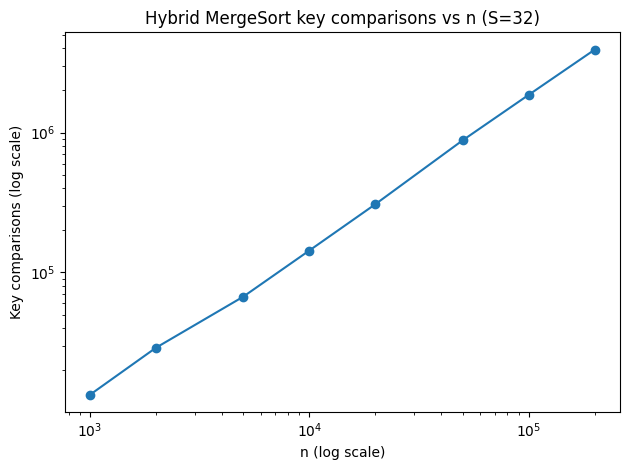

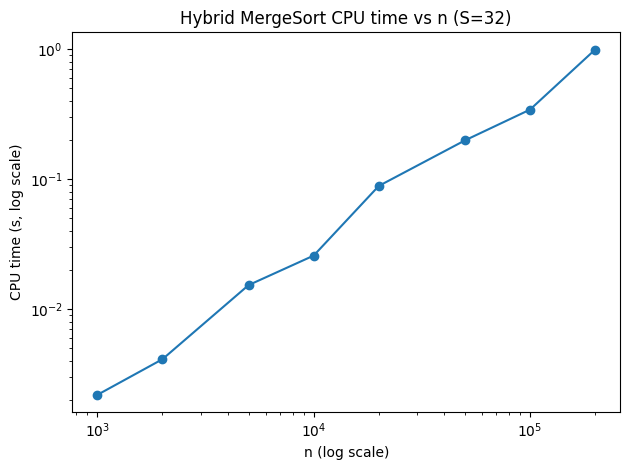

[fixed n=200,000] S=   2  comps≈3,272,453  time≈1.155s
[fixed n=200,000] S=   4  comps≈3,273,438  time≈1.133s
[fixed n=200,000] S=   6  comps≈3,309,653  time≈0.989s
[fixed n=200,000] S=   8  comps≈3,316,091  time≈0.785s
[fixed n=200,000] S=  10  comps≈3,316,091  time≈0.838s
[fixed n=200,000] S=  12  comps≈3,439,553  time≈0.855s
[fixed n=200,000] S=  14  comps≈3,478,974  time≈0.758s
[fixed n=200,000] S=  16  comps≈3,478,974  time≈0.740s
[fixed n=200,000] S=  18  comps≈3,478,974  time≈0.613s
[fixed n=200,000] S=  20  comps≈3,478,974  time≈0.610s
[fixed n=200,000] S=  22  comps≈3,478,974  time≈0.629s
[fixed n=200,000] S=  24  comps≈3,729,398  time≈0.767s
[fixed n=200,000] S=  26  comps≈3,924,869  time≈0.833s
[fixed n=200,000] S=  28  comps≈3,924,869  time≈0.778s
[fixed n=200,000] S=  30  comps≈3,924,869  time≈0.772s
[fixed n=200,000] S=  32  comps≈3,924,869  time≈0.985s
[fixed n=200,000] S=  34  comps≈3,924,869  time≈0.997s
[fixed n=200,000] S=  36  comps≈3,924,869  time≈0.936s
[fixed n=2

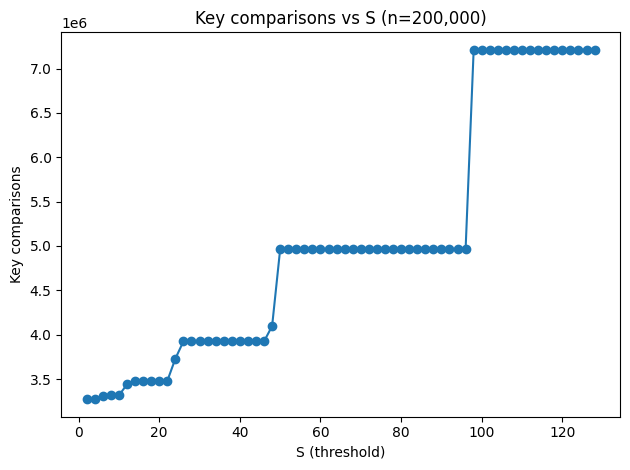

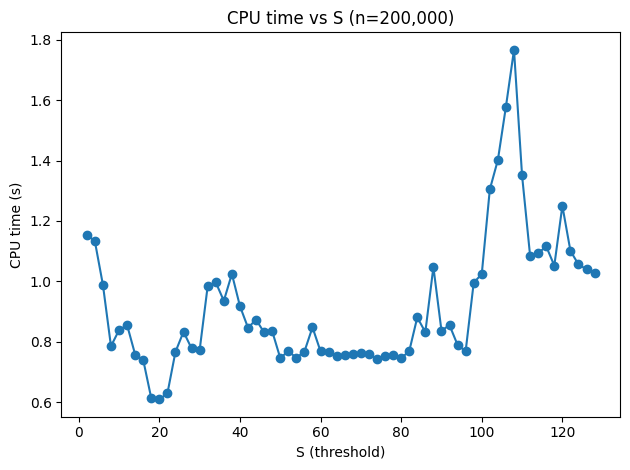

[optimal S] n=10,000  best S=10  time≈0.017s  comps≈126,919
[optimal S] n=20,000  best S=6  time≈0.040s  comps≈263,167
[optimal S] n=50,000  best S=8  time≈0.116s  comps≈729,111
[optimal S] n=100,000  best S=20  time≈0.258s  comps≈1,639,222
[optimal S] n=200,000  best S=10  time≈0.591s  comps≈3,315,622


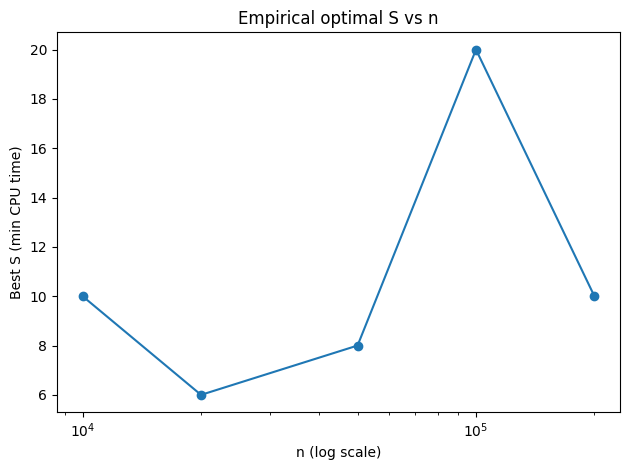

Using S_opt = 10


In [16]:
if __name__ == "__main__":
    # Choose the largest integer in [1..x_max]
    x_max = 10_000_000

    # (c)(i): fix S and vary n
    S_fixed = 32
    sizes = [1_000, 2_000, 5_000, 10_000, 20_000, 50_000, 100_000, 200_000]
    experiment_fixed_S_plot_vs_n(sizes, S_fixed, x_max, trials=1)

    # (c)(ii): fix n and vary S
    n_fixed = 200_000
    S_values = list(range(2, 129, 2))  # scan 2..128 step 2
    experiment_fixed_n_plot_vs_S(n_fixed, S_values, x_max, trials=1)

    # (c)(iii): optimal S across different n
    n_values = [10_000, 20_000, 50_000, 100_000, 200_000]
    S_scan = list(range(2, 129, 2))
    opt = find_optimal_S(n_values, S_scan, x_max, trials=1)

    # Pick an S_opt to use in (d), e.g. from n=200,000 or your largest tested n:
    S_opt = opt[max(opt.keys())][0]
    print("Using S_opt =", S_opt)